# Example: Path planning problem solved by [Symbolically guided Model Predictive Control (SgMPC)](https://doi.org/10.1016/j.ifacol.2022.09.039).

This example was adapted from the numerical experiments in [1, Sec. 5].
This is a **control problem** for a **discrete-time nonlinear system**.

Let us consider the 3-dimensional state space control system of the form
$$
x_{t+1} = f(x_t, u_t)
$$
with $f: \mathbb{R}^3 × \mathbb{R}^2 \to \mathbb{R}^3$ given by
$$
f(x, (u_1, u_2)) = \begin{bmatrix} x_1 + u_1 \cos(x_3) \\ x_2 + u_1 \sin(x_3) \\ x_3 + u_2 \ (\text{mod} \ 2\pi) \end{bmatrix}
$$
and with state and control constraints given by:
$$
X = \left\{ (x_1, x_2)^T \in \mathbb{R}^2 \ | \ x_1^2 - x_2^2 \leq 4, \ 4x_2^2 - x_1^2 \leq 16 \right\}
$$
$$
U = [0.2, 2] \times [-1, 1]
$$
Here, $(x_1, x_2)$ represents the 2D Cartesian coordinates and $x_3$ is the angular orientation of a mobile cart.
The control inputs $u_1$ and $u_2$ are the linear and angular velocities.
The control objective is to drive the mobile cart to a desired reference position $x_r$.


In order to validate the proposed Symbolically guided Model Predictive Control (SgMPC) strategy, the authors consider the following setup:

The optimization problem is set with a prediction horizon $N = 20$ and the stage cost:
$$
\ell(x, u) = 100 \|(x_1, x_2)^T - x_r\|^2 + \|u\|^2
$$
The terminal cost is:
$$
L(x) = 100 \|(x_1, x_2)^T - x_r\|^2
$$

Simulations are performed for two reference positions:
- $x_r = (0.5, 0.5)$
- $x_r = (\sqrt{32}/3, \sqrt{20}/3)$

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

Dionysos.Optim.Abstraction

And the file defining the hybrid system for this problem

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "path_planning_sgmpc.jl"))

Main.var"##645".PathPlanningSgMPC

### Definition of the problem

Defining the initial and target sets for the state-space of the system:

In [4]:
initial = SVector(1.0, -1.7, 0.0)
#initial = SVector(0.0, 0.0, 0.0)
#target = SVector(0.5, 0.5, -pi)
#target = SVector(2.6, 2.0, -pi)
#target = SVector(-2.6, 2.0, -pi)
target = SVector(sqrt(32.0 / 3.0), sqrt(20.0 / 3.0), -pi)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  3.265986323710904
  2.581988897471611
 -3.141592653589793

Now we instantiate the problem using the function provided by [PathPlanning.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/problems/PathPlanningSgMPC.jl)

In [5]:
concrete_problem = PathPlanningSgMPC.problem(; sgmpc = true, initial = initial, target = target)
concrete_system = concrete_problem.system;

### Definition of the abstraction

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

In [6]:
x0 = SVector(0.0, 0.0, 0.0);
h = SVector(0.1, 0.1, 0.2);
state_grid = DO.GridFree(x0, h);

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [7]:
u0 = SVector(1.1, 0.0);
h = SVector(0.3, 0.3);
input_grid = DO.GridFree(u0, h);

We now solve the optimal control problem with the `Abstraction.UniformGridAbstraction.Optimizer`.

In [8]:
using JuMP
optimizer = MOI.instantiate(AB.UniformGridAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.optimize!(optimizer)

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 21204363 transitions created
  2.065264 seconds (81 allocations: 686.292 MiB, 5.03% gc time)
compute_controller_reach! started

compute_controller_reach! terminated without covering init set


Get the results

In [9]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))
abstract_problem = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem"))
abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))

(::Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#10"{Dionysos.Optim.Abstraction.UniformGridAbstraction.var"#concrete_controller#9#11"{Dionysos.Symbolic.SymbolicModelList{3, 2, Dionysos.Domain.DomainList{3, Float64, Dionysos.Domain.GridFree{3, Float64}}, Dionysos.Domain.DomainList{2, Float64, Dionysos.Domain.GridFree{2, Float64}}, Dionysos.Symbolic.AutomatonList{Dionysos.Utils.SortedTupleSet{3, Tuple{Int64, Int64, Int64}}}}, Dionysos.Utils.SortedTupleSet{2, Tuple{Int64, Int64}}}}) (generic function with 1 method)

### Trajectory display
We choose a stopping criterion `reached` and the maximal number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space `_I_` defined previously.

In [10]:
nstep = 100
function reached(x)
    if x ∈ concrete_problem.target_set
        return true
    else
        return false
    end
end
x0 = initial #SVector(1.1, -1.6, 0.0)
control_trajectory = ST.get_closed_loop_trajectory(
    concrete_system.f,
    concrete_controller,
    x0,
    nstep;
    stopping = reached,
)

┌ Warning: Uncontrollable state
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/HRaG7/src/optim/abstraction/uniform_grid_abstraction.jl:148


Dionysos.System.Control_trajectory{StaticArraysCore.SVector{3, Float64}, Any}(Dionysos.System.Trajectory{StaticArraysCore.SVector{3, Float64}}(StaticArraysCore.SVector{3, Float64}[[1.0, -1.7, 0.0]]), Dionysos.System.Trajectory{Any}(Any[]))

Here we display the coordinate projection on the two first components of the state space along the trajectory.

In [11]:
fig = plot(; aspect_ratio = :equal);

We display the concrete domain

In [12]:
plot!(concrete_system.X; color = :yellow, opacity = 0.5);

We display the abstract domain

In [13]:
plot!(abstract_system.Xdom; color = :blue, opacity = 0.5);

We display the concrete specifications

In [14]:
plot!(concrete_problem.initial_set; color = :green, opacity = 0.2);
plot!(concrete_problem.target_set; dims = [1, 2], color = :red, opacity = 0.2);

We display the abstract specifications

In [15]:
plot!(
    SY.get_domain_from_symbols(abstract_system, abstract_problem.initial_set);
    color = :green,
);
plot!(
    SY.get_domain_from_symbols(abstract_system, abstract_problem.target_set);
    color = :red,
);

display(control_trajectory)

Dionysos.System.Control_trajectory{StaticArraysCore.SVector{3, Float64}, Any}(Dionysos.System.Trajectory{StaticArraysCore.SVector{3, Float64}}(StaticArraysCore.SVector{3, Float64}[[1.0, -1.7, 0.0]]), Dionysos.System.Trajectory{Any}(Any[]))

We display the concrete trajectory

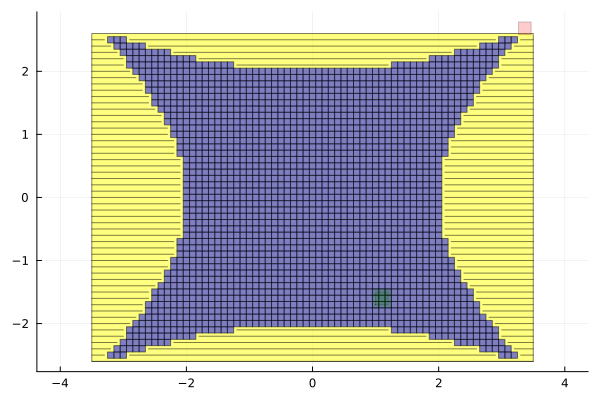

In [16]:
plot!(control_trajectory; ms = 0.5)

### References
1. Z. Azaki, A. Girard and S. Olaru, "Predictive and Symbolic Control: Performance and Safety for Non-linear Systems," in IFAC-PapersOnLine, 2022, vol. 55, no 16, pp. 290-295..

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*